# Analyse BlueSeis BSPF Event Analysis - Polarization

With pressure sensor parascientific and new sensor 

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")
from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
from functions.request_data import __request_data

In [3]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

In [4]:
from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)

## Configurations

In [5]:
workdir = "/home/andbro/Documents/ROMY/BSPF"

In [6]:
config = {}

## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*"
# config['seed_seismometer'] = "PY.BSPF..HH*"

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643


## Borrego Springs, Ca M3.2 -> good
# config['tbeg'] = obs.UTCDateTime("2023-01-09 19:42:56")-3
# config['tend'] = config['tbeg']+35
# config['fmin'], config['fmax'] = 0.1, 15.0
# config['magnitude'] = 3.2
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Las Brisas M6.2 -> alright
# config['eventtime'] = obs.UTCDateTime("2022-11-22 16:39")
# config['tbeg'] = obs.UTCDateTime("2022-11-22 16:32")+30
# config['tend'] = config['tbeg']+1000
# config['fmin'], config['fmax'] = 0.01, 0.5
# config['magnitude'] = 6.3
# config['title'] = f"Las Brisas, Mexico | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Borrego Springs, California M4.2 -> good
config['eventtime'] = obs.UTCDateTime("2022-12-31 12:12:26")
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:27")
config['tend'] = obs.UTCDateTime("2022-12-31 12:13")
config['magnitude'] = 4.2
config['fmin'], config['fmax'] = 0.1, 0.8
config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M4.2"

## store config
__store_as_pickle(config, f"./configs/{str(config['tbeg'].date).replace('-','')}_M{config['magnitude']}.pkl")

## Load Data

In [7]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("IRIS")

    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net,
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")
        inventory = None

    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha,
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        waveform = None
    
    return waveform, inventory

In [8]:
py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

In [9]:
ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])

## PreProcessing

In [10]:
def __process_acc_data(config, st, inv):
    
    ii_pfo_acc = st.copy()


    ## cut properly
    ii_pfo_acc.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo_acc.detrend("demean")

    ## remove response
    ii_pfo_acc.remove_response(inventory=inv, 
                           output="ACC",
                           plot=False)

    ## taper 
    ii_pfo_acc.taper(0.1)

    ## bandpass
    ii_pfo_acc.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    ii_pfo_acc.detrend("demean")
    
    ## adjust channel names
    for tr in ii_pfo_acc:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")

    ## show stream
    print(ii_pfo_acc)
            
    ii_pfo_acc.plot(equal_scale=False);
    
    return ii_pfo_acc

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1321 samples
II.PFO.10.BHE | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1321 samples
II.PFO.10.BHZ | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1321 samples


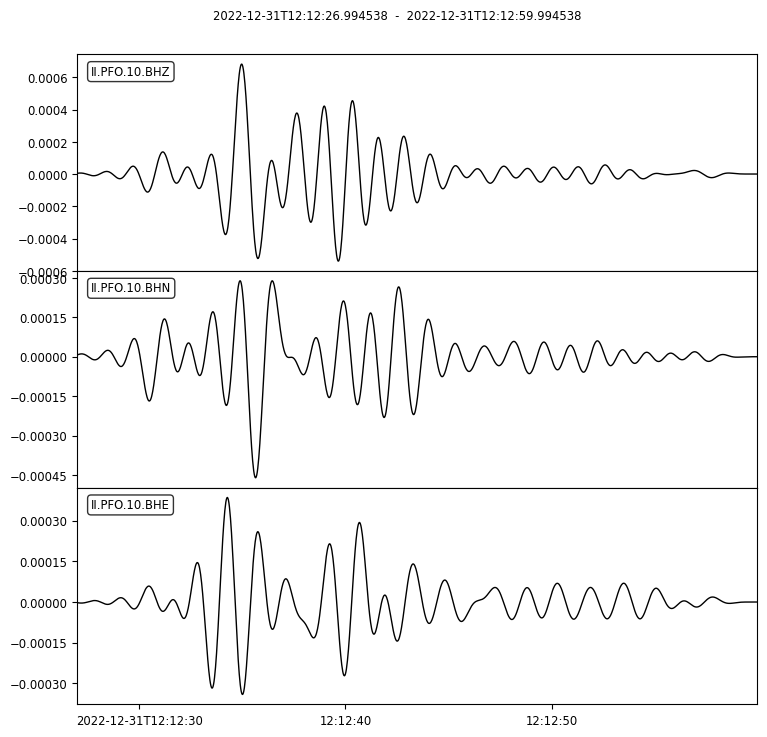

In [11]:
ii_pfo_acc = __process_acc_data(config, ii_pfo0, ii_pfo_inv)

In [12]:
def __process_rot_data(config, st, inv):
    
    py_bspf = st.copy()

    ## merge traces that might be split due to data gaps or overlaps
    py_bspf.merge(fill_value="interpolate")

    ## renove sensitivity
    py_bspf.remove_sensitivity(inv)
    
    ## resample to 40 Hz as acc data
    py_bspf.resample(40)
    
    ## cut to event
    py_bspf.trim(config['tbeg'], config['tend'])
    
    ## remove mean
    py_bspf.detrend("demean")

    ## apply taper
    py_bspf.taper(0.1)

    ## bandpass filter
    py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    py_bspf.detrend("demean")    
    

    
    ## adjust channel names
    for tr in py_bspf:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","E")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","N")        
        if tr.stats.channel[-1] == "3":
            tr.stats.channel = str(tr.stats.channel).replace("3","Z")

    ## show all traces in data stream
    print(py_bspf)

    py_bspf.plot(equal_scale=False);

    return py_bspf

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1321 samples
PY.BSPF..HJN | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1321 samples
PY.BSPF..HJZ | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1321 samples


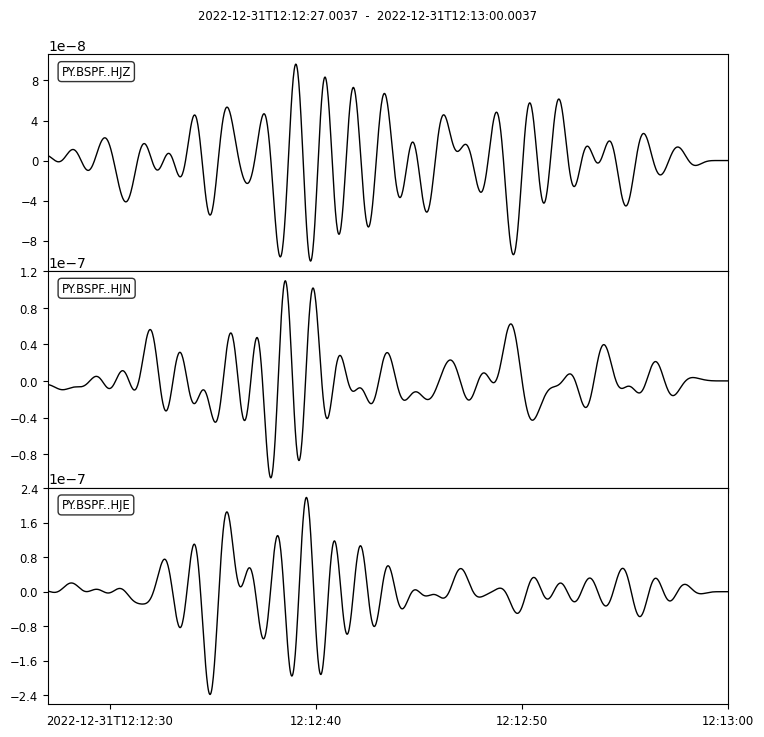

In [13]:
py_bspf = __process_rot_data(config, py_bspf0, py_bspf_inv)

## S-Transform

In [14]:
def __makeplotStream_cwt(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    from numpy import array, log10, logspace, linspace
    from obspy.signal.tf_misfit import cwt
    from obspy.imaging.cm import obspy_sequential
    
    import matplotlib.pyplot as plt

    keys_expected = ['fmin', 'fmax']
    for key in keys_expected:
        if key not in config.keys():
            print(" -> keys missing in config")
            print(keys_expected)
            return
    
    
    NN = len(st)
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e3, r"mm/s"
        
#     fig, axes = plt.subplots(NN,2,figsize=(13, int(NN*2)), sharex='col')
    fig, axes = plt.subplots(NN,2,figsize=(16, 12), sharex='col')

    font = 18
    
    plt.subplots_adjust(hspace=0.1, wspace=0.2)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    

    for i, tr in enumerate(st):

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling
            
#         t = tr.times()
        t = np.linspace(0, tr.stats.delta * tr.stats.npts, tr.stats.npts)
        
#         tr = tr.normalize()
        
        scalogram = cwt(tr.data, tr.stats.delta, 8, config['fmin'], config['fmax'])

        x, y = np.meshgrid(t, logspace(log10(config['fmin']), log10(config['fmax']), scalogram.shape[0]))
#         x, y = np.meshgrid(t, linspace(config['fmin'], config['fmax'], scalogram.shape[0]))
         
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J" and tr.stats.station == "BSPF":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)    
        
        if tr.stats.channel[-2] == "J" and tr.stats.station == "RPFO":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='darkred',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)    


        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='darkblue',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
            axes[i,1].pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)    
        
#         axes[i,1].set_yscale("log")
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$ ", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "$\ddot{u}$", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'$f$ (Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,0].tick_params(axis="y", labelsize=15)
        axes[i,0].tick_params(axis="x", labelsize=15)
        axes[i,1].tick_params(axis="y", labelsize=15)
        axes[i,1].tick_params(axis="x", labelsize=15)
        
    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    

    return fig

In [15]:
st_all = obs.Stream()
st_all += py_bspf.copy()
st_all += ii_pfo_acc.copy()

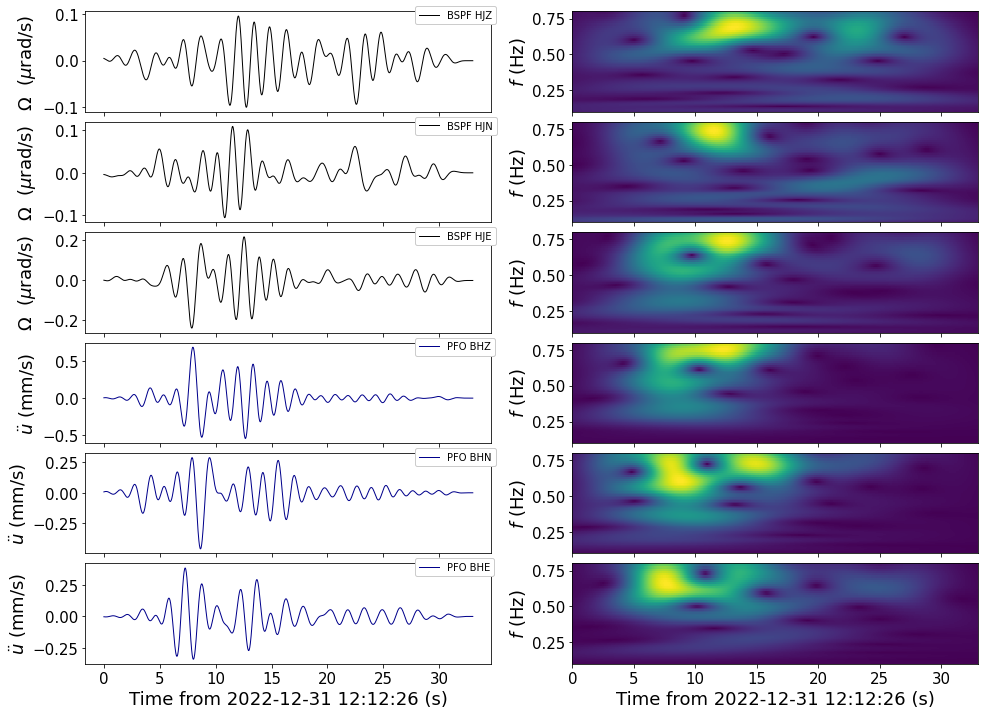

In [16]:
fig = __makeplotStream_cwt(st_all, config);

## Frequency Domain

In [17]:
from twistpy.polarization import TimeFrequencyAnalysis6C, EstimatorConfiguration

In [18]:
acc = ii_pfo_acc.copy()
rot = py_bspf.copy()

acc.resample(20.0)
rot.resample(20.0)

scaling_velocity = 5000 # m/s

for tr1, tr2 in zip(acc, rot):
    tr1.taper(0.1);  tr2.taper(0.1)
    tr1.detrend("linear") ; tr2.detrend("linear")
    
for tr in acc: 
    tr.data /= scaling_velocity


window = {"number_of_periods": 2, "frequency_extent": 0.01}

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples
II.PFO.10.BHE | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples
II.PFO.10.BHZ | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples
PY.BSPF..HJN | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples
PY.BSPF..HJZ | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

II.PFO.10.BHN | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

PY.BSPF..HJE | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

II.PFO.10.BHN | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

PY.BSPF..HJE | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

II.PFO.10.BHE | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

PY.BSPF..HJN | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

II.PFO.10.BHE | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

PY.BSPF..HJN | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

II.PFO.10.BHZ | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

PY.BSPF..HJZ | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

II.PFO.10.BHZ | 2022-12-31T12:12:26.994538Z - 2022-12-31T12:12:59.944538Z | 20.0 Hz, 660 samples

PY.BSPF..HJZ | 2022-12-31T12:12:27.003700Z - 2022-12-31T12:12:59.953700Z | 20.0 Hz, 660 samples

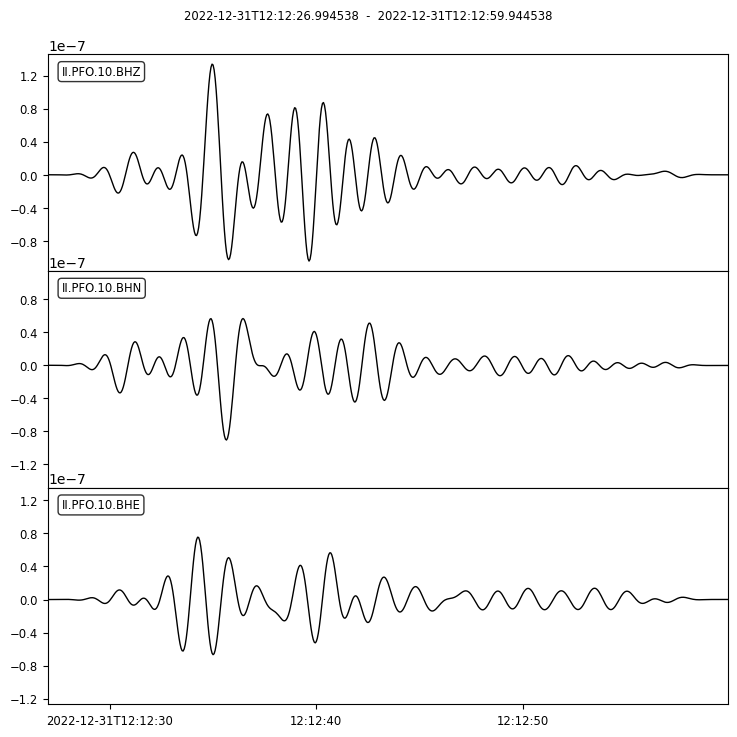

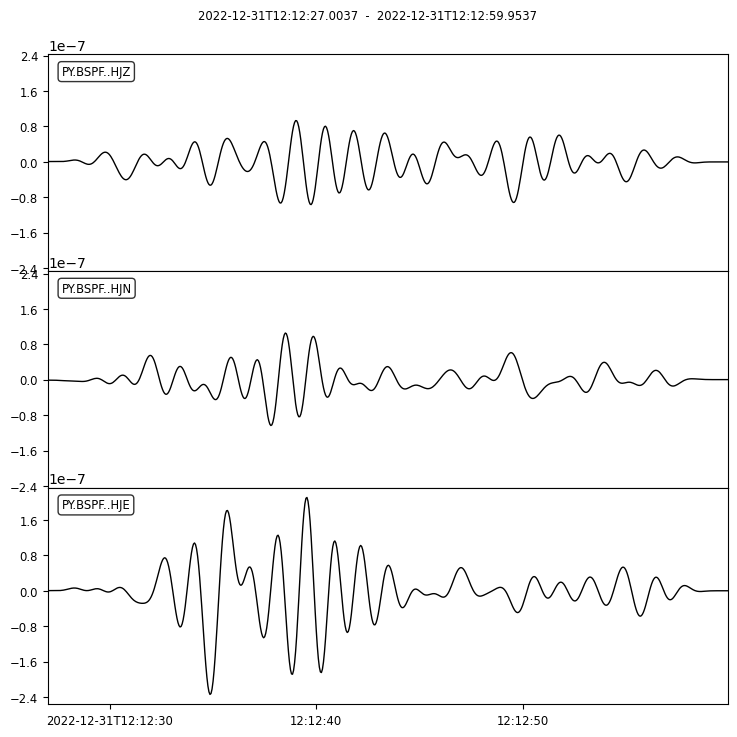

(<Figure size 800x750 with 3 Axes>, <Figure size 800x750 with 3 Axes>)

In [19]:
acc.plot(), rot.plot()

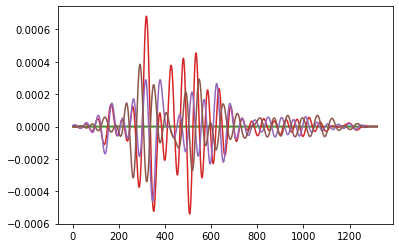

In [20]:
%matplotlib inline


for tr in st_all:
    plt.plot(tr.data)
plt.show()

In [21]:
analysis = TimeFrequencyAnalysis6C(
                                    traN=acc.select(channel="*N")[0],
                                    traE=acc.select(channel="*E")[0],
                                    traZ=acc.select(channel="*Z")[0],
                                    rotN=rot.select(channel="*N")[0],
                                    rotE=rot.select(channel="*E")[0],
                                    rotZ=rot.select(channel="*Z")[0],
                                    window=window,
                                    dsfacf=100,
                                    dsfact=1,
                                    frange=[0.01, 15.0],
                                    scaling_velocity=scaling_velocity,
)

Computing covariance matrices...
Covariance matrices computed!


In [22]:
est = EstimatorConfiguration(
                            wave_types=["R"],
                            method="DOT",
                            scaling_velocity=scaling_velocity,
                            use_ml_classification=False,
                            vr=[2000, 4000, 100],
                            xi=[-90, 90, 2],
                            phi=[0, 360, 10],
                            eigenvector=0,

)

In [23]:
analysis.polarization_analysis(estimator_configuration=est)

Computing wave parameters...
Estimating wave parameters for R-Waves...
Done!


In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


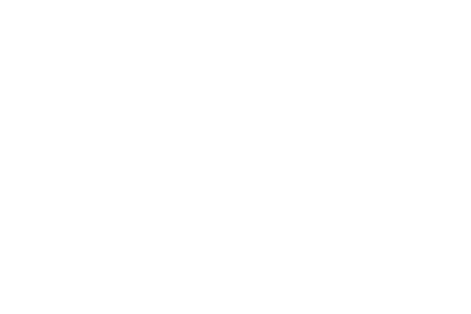

<IPython.core.display.Javascript object>


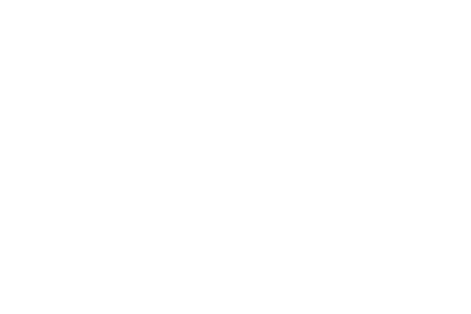

In [25]:
# %matplotlib notebook

analysis.plot_wave_parameters(estimator_configuration=est, lh_min=0.5, lh_max=1.0)

## Polarization Analysis

In [26]:
dt = py_bspf[0].stats.delta

scaling_velocity = 5000.0

### Train Model

In [27]:
svm = SupportVectorMachine(name="love_wave_test2")

########################################################################################################################
# Now we can train the model. For details, please check the example on how to train a
# 'twistpy.machinelearning.SupportVectorMachine' object. In short, we want to train the model for wave parameters
# that are typical for the near surface, and we want to be able to identify P, SV, SH and Rayleigh waves. This means
# that we do not make a distinction between Love and SH waves here, and Love waves will simply be contained in the SH
# wave class as the special case of horizontally propagating SH waves. Additionally, we make use of a Noise class, for
# analysis windows with a random polarization. We allow waves to arrive from all directions (azimuth range [0 360]
# degrees and inclination range [0 90] degrees).

svm.train(
            wave_types=["R", "P", "SV", "L", "Noise"],
            N=5000,
            scaling_velocity=scaling_velocity,
            vp=(2000, 4000),
            vp_to_vs=(1.7, 2.4),
            vl=(100, 3000),
            vr=(100, 3000),
            phi=(0, 360),
            theta=(0, 90),
            xi=(-90, 90),
            free_surface=True,
            C=1,
            kernel="rbf",
)

Generating random polarization models for training! 

Training Support Vector Machine!
Training successfully completed. Model score on independent test data is '0.9632'!
Model has been saved as '/home/brotzer/TwistPy/twistpy/SVC_models/love_wave_test2.pkl'!'


AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

## Prepare

In [ ]:
rot = py_bspf.copy().trim(config['tbeg'], config['tend']).taper(0.1)
acc = ii_pfo_acc.copy().trim(config['tbeg'], config['tend']).taper(0.1)

In [ ]:
acc.select(channel="*Z")[0].data *= -1
rot.select(channel="*Z")[0].data *= -1

In [ ]:
for tr in acc:
    tr.data /= scaling_velocity

In [ ]:
# acc.plot();
# rot.plot();

## Time Domain

In [ ]:
acc[0].stats.

In [ ]:
########################################################################################################################
# Now that we have trained the model, we can set up our analysis. We will perform 6C polarization analysis in the time
# domain and use a sliding time window that is 0.05 s long (50 samples) with an overlap between subsequent windows of
# 50%.

dt = py_bspf[0].stats.delta

window = {"window_length_seconds": 5 * dt, "overlap": 50}

analysis = TimeDomainAnalysis6C(
                                traN=acc.select(channel="*N")[0],
                                traE=acc.select(channel="*E")[0],
                                traZ=acc.select(channel="*Z")[0],
                                rotN=rot.select(channel="*N")[0],
                                rotE=rot.select(channel="*E")[0],
                                rotZ=rot.select(channel="*Z")[0],
                                window=window,
                                scaling_velocity=scaling_velocity,
)

In [ ]:
%matplotlib inline

In [ ]:
########################################################################################################################
# To classify the waves, we simply do (yielding a classification of the first eigenvector of the covariance matrix):

analysis.classify(svm=svm, eigenvector_to_classify=0)

classification = analysis.classification["0"]

t_windows = (analysis.t_windows)  # Positions of the sliding time windows where the classification was performed

#  Wave parameter estimation

# est = EstimatorConfiguration(
#                             wave_types=["L", "R"],
#                             method="DOT",
#                             scaling_velocity=scaling_velocity,
#                             use_ml_classification=False,
    
#                             svm=svm,
# )

est = EstimatorConfiguration(
                            wave_types=["R"],
                            method="DOT",
                            scaling_velocity=scaling_velocity,
                            use_ml_classification=False,
                            vr=[1000, 4500, 100],
                            xi=[-90, 90, 2],
                            phi=[0, 360, 10],
                            eigenvector=0,
                            svm=svm,
)


analysis.polarization_analysis(estimator_configuration=est)

analysis.plot(estimator_configuration=est, dop_clip=0.9)


In [ ]:
time domain grid search für parameter



## Test Example

In [ ]:
# data = obs.read("/home/andbro/Documents/ROMY/twistpy/TwistPy/example_data/ROMY_gulf_of_alaska_teleseism.mseed")

# # scaling_velocity = 4500.0

# for n, trace in enumerate(data):
#     trace.detrend("spline", order=5, dspline=100)
#     trace.trim(starttime=trace.stats.starttime, endtime=trace.stats.endtime - 4500)
#     trace.taper(0.2)
#     if n < 3:
#         trace.data /= scaling_velocity

# window = {"number_of_periods": 1, "frequency_extent": 0.01}

# analysis = TimeFrequencyAnalysis6C(
#     traN=data[0],
#     traE=data[1],
#     traZ=data[2],
#     rotN=data[3],
#     rotE=data[4],
#     rotZ=data[5],
#     window=window,
#     dsfacf=20,
#     dsfact=20,
#     frange=[0.01, 0.15],
# )

# est = EstimatorConfiguration(
#     wave_types=["R"],
#     method="DOT",
#     scaling_velocity=scaling_velocity,
#     use_ml_classification=False,
#     vr=[3000, 4000, 100],
#     xi=[-90, 90, 2],
#     phi=[150, 210, 1],
#     eigenvector=0,
# )

# analysis.plot_wave_parameters(estimator_configuration=est, lh_min=0.7, lh_max=1.0)
